# All functions needed for curve fitting
* get runtimes data: ```gcloud compute operations --format=json list > m21.json```
* get instance types: ```gcloud compute instances list > instances-m21.txt```

In [230]:
#Filtering data based on machine type
import json
import pandas as pd
import numpy as np
import time
import datetime
import dateutil.parser 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit
import glob
import inspect

In [231]:
#Instance types as a dic
def get_instance_types(path):
    try:
        frames = [ pd.read_csv(file,delim_whitespace=True, header=None) for file in sorted(glob.iglob(path)) ]
        instance_info = pd.concat(frames)
        instances = pd.Series(instance_info[2].values,index=instance_info[0].values).to_dict()
        del instances['NAME']
    except Exception as msg:
        print(msg)
        raise
    return instances
    
# convert to mins
def ttl_in_minutes(start_time, end_time):
    s=dateutil.parser.parse(start_time)
    e=dateutil.parser.parse(end_time)
    diff = e-s
    return diff.total_seconds()

#get all runtime information
def get_runtimes(path):
    out = dict()
    try:
        for file in sorted(glob.iglob(path)):
            with open(file) as json_file:  
                data = json.load(json_file)

            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']
                if not iname in out:
                    if entry['operationType']=='insert':
                        out[iname] = (entry, np.nan)

            #Adding time data
            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']      
                if entry['operationType']=='compute.instances.preempted':
                    if iname in out:
                        orig_entry = out[iname][0]
                        start_time = orig_entry['insertTime']
                        end_time = entry['insertTime']
                        ttl = ttl_in_minutes(start_time, end_time)
                        out[iname] = (orig_entry, ttl)

        #removing the datapoint which did not have endtime
        #removing the datapoint which have longer time than 30 hours
        for i in list(out):
            if np.isnan(out[i][1]):
                out.pop(i)
            elif (out[i][1]/3600.0 > 30):
                print(out[i][0]['targetLink'])
                out.pop(i)
    except Exception as msg:
        print(msg)
        raise
    return out

#Creating lists for eah machine type
def get_runtimes_for_machine_type(runtimes, instances):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        assert(isinstance(instances, dict))
        for key, value in runtimes.items():   
            iname = key.split('/')[-1]
            if iname in instances:
                if instances[iname] in all_data:
                    all_data[instances[iname]].append(value[1]/3600.0)
                else:
                    all_data[instances[iname]] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data

In [232]:
1.0 - math.pow(np.exp(-2/0.3), 2)

0.9999983804032077

In [233]:
#curve fitting sinh
def func_approx(t, R, t0, tau, C):
    return R*np.sinh((t-t0)/tau) + C

def func_approx_5_param_expon(t, A, B, tau1, tau2, C):
    return A*np.exp(-t/tau1) + B*np.exp(t/tau2) + C


def func_approx_4_param_expon(t, A, b, tau1, tau2):
    return A*(1.0-np.exp(-t/tau1) + np.exp((t-b)/tau2))

def func_approx_weibull(t, rate, k):
    return (1.0 - math.pow(np.exp(-t*rate), k))

#curve fitting inverse sinh
def func_approx_inverse_by_interpolation(value, R, t0, tau, C):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx(t, R, t0, tau, C)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#curve fitting inverse: This is junk due to periodic? behaviour sinh
def func_approx_inverse(f, R, t0, tau, C):
    return tau*np.arcsinh((f/R)-C) + t0

#derivative of the function sinh
def func_approx_dif(t, R, t0, tau, C):
    return R*np.cosh((t-t0)/tau)/tau

#Expected value function sinh
def func_approx_exp(t, R, t0, tau, C):
    return t*R*np.cosh((t-t0)/tau)/tau

#curve fitting exp
def func_approx_exponential(t, alpha):
    return (1.0 - np.exp(-alpha*t))

#curve fitting inverse sinh
def func_approx_exponential_inverse_by_interpolation(value, alpha):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx_exponential(t, alpha)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#derivative of the function exp
def func_approx_exponential_dif(t, alpha):
    return alpha*np.exp(-alpha*t)

#Expected value function exp
def func_approx_exponential_exp(t, alpha):
    return t*alpha*np.exp(-alpha*t)


# Compute the cross_entropy between two arrays
def cross_entropy(prediction, empirical, epsilon=1e-12):
    prediction = np.clip(prediction, epsilon, 1. - epsilon)
    return -np.sum(empirical*np.log(prediction+1e-9))/prediction.shape[0]

# Compute the MSE between two arrays
def mean_square_error(prediction, empirical):
    return (np.square(empirical - prediction)).mean(axis=0)

In [5]:
#generate curve fitting for all the data for one of the machine grouping
def fit_data(all_data_conc, func_approx, func_approx_exp):
    temp_data = dict() 
    try:
        #Check whether data size is at least 4 points and if it has points in span of 10 hrs
        if (len(all_data_conc) > 3) and ((max(all_data_conc) - min(all_data_conc)) > 10 ): 
            temp_data['t'] = np.sort(all_data_conc)
            temp_data['cdf'] = np.linspace(0,1,len(all_data_conc), endpoint=True)
            #fit the curve: method= 'trf', 'dogbox' or 'lm'
            #‘trf’ : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
            #‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
            #‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
            optimized_param, param_covariance = curve_fit(func_approx, temp_data['t'], temp_data['cdf'], maxfev=10000, method='dogbox')
            temp_data['optimized_params'] = optimized_param
            temp_data['param_covariance'] = param_covariance
            # Cross Entropy between fit and empirical data
            temp_data['cross_entropy'] = cross_entropy(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
             # MSE between fit and empirical data
            temp_data['mean_square_error'] = mean_square_error(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
            #Expected value computation
            I = quad(func=func_approx_exp, a=temp_data['t'][0], b=temp_data['t'][-1],args=tuple(optimized_param))
            temp_data['expected_value'] = I
    except Exception as msg:
        print(msg)
        raise
    return temp_data


#generate curve fitting data for all the curves considering machine grouping
def fit_all_types(all_data, func_approx, func_approx_exp):
    optimized_params = dict() 
    try:
        for key, value in all_data.items():
            #Check whether data size is at least 4 points and if it has points in span of 10 hrs
            if (len(value) > 3) and ((max(value) - min(value)) > 10 ):
                optimized_params[key] = fit_data(value, func_approx, func_approx_exp)
    except Exception as msg:
        print(msg)
        raise
    return optimized_params

In [6]:
# Plot the curve fitting data
def plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    plt.title(text)

# Plot the curve fitting data
def plot_two_CDF(key, value,value2, func_approx, func_approx_dif, func_approx_inverse_by_interpolation,  
                 func_approx2, func_approx_dif2, func_approx_inverse_by_interpolation2):
    
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    
    #2nd plot
    edge_point_near_one2 = func_approx_inverse_by_interpolation2(value2['t'][-1],*value2['optimized_params'] )
    t2=np.linspace(0, edge_point_near_one2, 10000, endpoint=True)
    plt.plot(t2, func_approx2(t2, *value2['optimized_params']), c= "black",  label='F2(t)')
    #plt.plot(t2, func_approx_dif2(t2, *value2['optimized_params']), c= "purple", label='dF2(t)')
    
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    plt.title(text)    
    
# Plot the curve fitting data
def plot_all_types(optimized_params, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    try:
        for key, value in optimized_params.items():
            #Plot text
            plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)
            
    except Exception as msg:
        print(msg)
        raise

# Get runtime data per machine type

In [234]:
#Get instance data
instances = get_instance_types('instance-data/instances*.txt')

#Get runtime data
runtime_data = get_runtimes('runtime-data/*.json')

#Get runtime data per machine type
all_data = get_runtimes_for_machine_type(runtime_data, instances)

print(all_data)

https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus2
https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus3
{'n1-highcpu-16': array([  1.56550000e-02,   2.06522222e-02,   2.60625000e-02,
         4.22347222e-02,   4.23300000e-02,   4.60180556e-02,
         4.95291667e-02,   5.87708333e-02,   6.13402778e-02,
         7.55827778e-02,   9.66683333e-02,   1.01422500e-01,
         1.13430000e-01,   1.21216389e-01,   1.39953333e-01,
         1.62339167e-01,   1.81601667e-01,   2.18206111e-01,
         2.28482222e-01,   2.50938889e-01,   2.78716111e-01,
         2.85486667e-01,   3.48897222e-01,   4.11558889e-01,
         4.29898889e-01,   4.40400000e-01,   5.00317778e-01,
         6.17813889e-01,   6.64430278e-01,   7.11705833e-01,
         7.69942778e-01,   7.87950278e-01,   8.59603611e-01,
         9.50201944e-01,   9.69013889e-01,   1.21000139e+00,
         1.48938333e+00,   1.95820972e+00,   2.19073861e+00,

# Curve fitting with sinh for for all the results without considering machine type

In [8]:
all_data_conc = []
for key, value in all_data.items():
    for i in range(value.shape[0]):
        all_data_conc.append(value[i]) 

        

In [9]:
all_data_conc

[0.015655,
 0.02065222222222222,
 0.026062500000000002,
 0.04223472222222222,
 0.04233,
 0.046018055555555555,
 0.049529166666666666,
 0.05877083333333333,
 0.06134027777777777,
 0.07558277777777778,
 0.09666833333333333,
 0.1014225,
 0.11343,
 0.12121638888888889,
 0.13995333333333332,
 0.18160166666666666,
 0.21820611111111113,
 0.2284822222222222,
 0.2509388888888889,
 0.2787161111111111,
 0.28548666666666667,
 0.3488972222222222,
 0.4115588888888889,
 0.4298988888888889,
 0.4404,
 0.5003177777777778,
 0.6178138888888889,
 0.6644302777777777,
 0.7117058333333334,
 0.7699427777777778,
 0.7879502777777778,
 0.859603611111111,
 0.9502019444444444,
 0.9690138888888888,
 1.210001388888889,
 1.4893833333333333,
 1.9582097222222223,
 2.190738611111111,
 2.2340252777777776,
 2.4329855555555553,
 2.5363416666666665,
 2.687321388888889,
 2.7398966666666666,
 2.8316275,
 2.979945277777778,
 3.0715591666666664,
 3.3365755555555556,
 3.5015952777777777,
 3.6251305555555553,
 3.804773611111111,
 

In [235]:
def simple_fit(all_data_conc, func_approx, p0=None):
    #ACHTUNG. Initial parameters only for 
    temp_data = dict()
    temp_data['t'] = np.sort(all_data_conc)
    temp_data['cdf'] = np.linspace(0,1,len(all_data_conc), endpoint=True)
    optimized_param, param_covariance = curve_fit(func_approx, temp_data['t'], temp_data['cdf'],\
                                                  maxfev=100000, method='lm',
                                                 p0=p0)
    temp_data['optimized_params'] = optimized_param
    temp_data['param_covariance'] = param_covariance
    return temp_data

In [236]:
all_data['n1-highcpu-16']

array([  1.56550000e-02,   2.06522222e-02,   2.60625000e-02,
         4.22347222e-02,   4.23300000e-02,   4.60180556e-02,
         4.95291667e-02,   5.87708333e-02,   6.13402778e-02,
         7.55827778e-02,   9.66683333e-02,   1.01422500e-01,
         1.13430000e-01,   1.21216389e-01,   1.39953333e-01,
         1.62339167e-01,   1.81601667e-01,   2.18206111e-01,
         2.28482222e-01,   2.50938889e-01,   2.78716111e-01,
         2.85486667e-01,   3.48897222e-01,   4.11558889e-01,
         4.29898889e-01,   4.40400000e-01,   5.00317778e-01,
         6.17813889e-01,   6.64430278e-01,   7.11705833e-01,
         7.69942778e-01,   7.87950278e-01,   8.59603611e-01,
         9.50201944e-01,   9.69013889e-01,   1.21000139e+00,
         1.48938333e+00,   1.95820972e+00,   2.19073861e+00,
         2.23402528e+00,   2.43298556e+00,   2.53634167e+00,
         2.68732139e+00,   2.73989667e+00,   2.83162750e+00,
         2.97994528e+00,   3.07155917e+00,   3.33657556e+00,
         3.50159528e+00,

In [12]:
data_to_fit = all_data_conc

In [13]:
fit_params = simple_fit(data_to_fit, func_approx_4_param_expon,p0=[1,23,1,1])

In [14]:
fit_params['optimized_params']

array([ 0.40012111, 24.43263072,  0.85633935,  0.74419522])

In [15]:
fit_params2 = simple_fit(data_to_fit, func_approx_exponential)

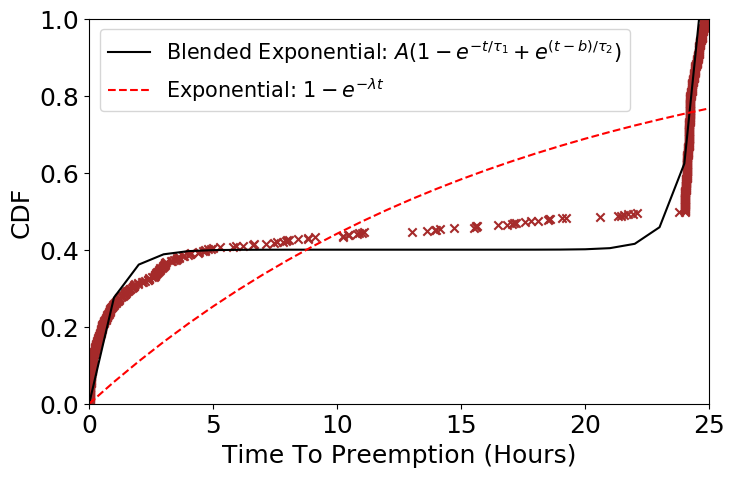

In [17]:
t=np.arange(0,26)
Y = np.sort(data_to_fit)
X = np.linspace(0,1,len(data_to_fit), endpoint=True)
matplotlib.rcParams.update({'font.size': 18})
fig,ax = plt.subplots()
fig.set_size_inches(8,5)
ax.scatter(Y, X, marker='x',color='brown')
ax.plot(t, func_approx_4_param_expon(t, *fit_params['optimized_params']), c='k',  label=r'Blended Exponential: $A(1-e^{-t/\tau_1}+e^{(t-b)/ \tau_2})$')
ax.plot(t, func_approx_exponential(t, *fit_params2['optimized_params']), c='r', linestyle='--', label=r'Exponential: $1-e^{-\lambda t}$')

ax.set_ylim((0,1))
ax.set_xlim((0,25))
ax.legend(fontsize='small')
ax.set_xlabel("Time To Preemption (Hours)")
ax.set_ylabel("CDF")
plt.savefig("../graphs/cdf_4_all.pdf",bbox_inches='tight')

In [18]:
def fit_and_plot(all_data, mtype):
    if mtype is None:
        data_to_fit = all_data_conc
    else:
        data_to_fit = all_data[mtype]
    fit_params = simple_fit(data_to_fit, func_approx_4_param_expon,p0=[1,23,1,1])
    print(fit_params['optimized_params'])
    matplotlib.rcParams.update({'font.size': 18})
    t=np.arange(0,26)
    Y = np.sort(data_to_fit)
    X = np.linspace(0,1,len(data_to_fit), endpoint=True)
    fig,ax = plt.subplots()
    fig.set_size_inches(8,5)
    ax.scatter(Y, X, marker='x',color='brown')
    ax.plot(t, func_approx_4_param_expon(t, *fit_params['optimized_params']), c='k',  label=r'Blended Exponential: $A(1-e^{-t/\tau_1}+e^{(t-b)/ \tau_2})$')

    ax.set_ylim((0,1))
    ax.set_xlim((0,25))
    ax.legend(fontsize='small')
    ax.set_xlabel("Time To Preemption (Hours)")
    ax.set_ylabel("CDF")
    
    #plt.savefig("../graphs/cdf_4_all.pdf",bbox_inches='tight')

In [19]:
len(all_data_conc)

607

[ 0.41884574 24.44580603  0.98162548  0.78469816]


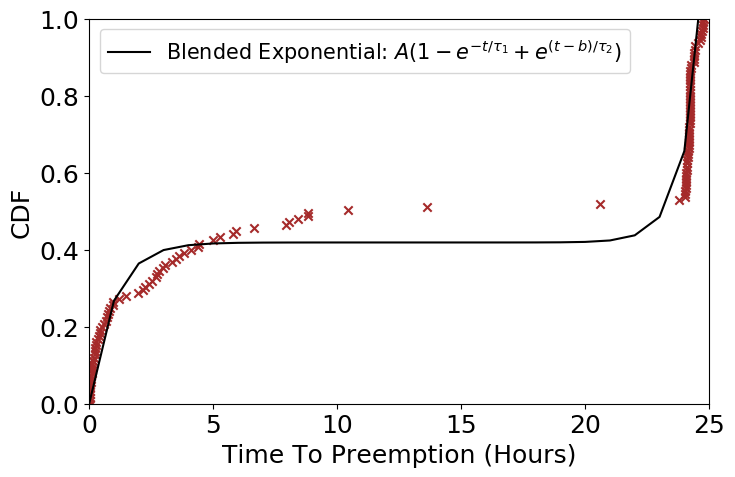

In [20]:
fit_and_plot(all_data, 'n1-highcpu-16')

[ 0.40012111 24.43263072  0.85633935  0.74419522]


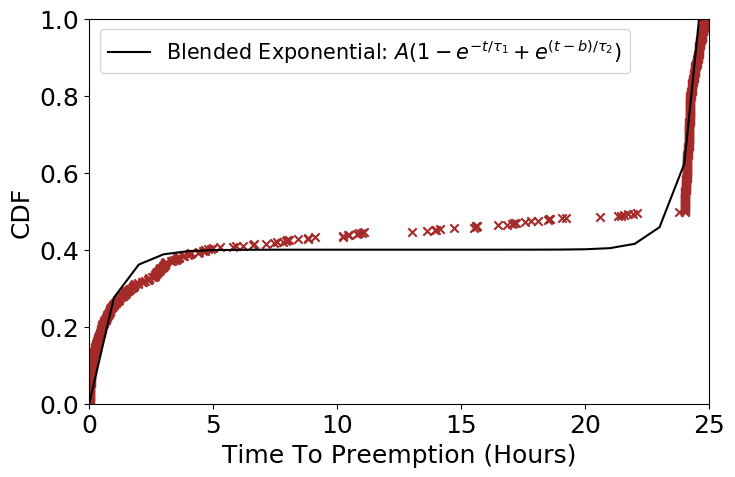

In [21]:
fit_and_plot(all_data, None)

In [22]:
import itertools

In [23]:
def plot_for_comparison(all_data, machine_list):
    matplotlib.rcParams.update({'font.size': 18})
    fig,ax = plt.subplots()
    colors = itertools.cycle(['r','k', 'brown'])
    for m in machine_list:
        data_to_fit = all_data[m]
        fit_params = simple_fit(data_to_fit, func_approx_4_param_expon,p0=[1,23,1,1])
        print(fit_params['optimized_params'])
        t=np.arange(0,26)
        Y = np.sort(data_to_fit)
        X = np.linspace(0,1,len(data_to_fit), endpoint=True)
        fig.set_size_inches(10,6)
        color=next(colors)
        ax.scatter(Y, X, marker='x',color=color)
        (A, b, tau1, tau2) = fit_params['optimized_params']
        detailed_label=m+r": $A={0:.2f}, b={1:.2f}, \tau_1={2:.2f}, \tau_2={3:.2f}$".format(A,b,tau1,tau2)
        print(detailed_label)
        ax.plot(t, func_approx_4_param_expon(t, *fit_params['optimized_params']),\
                color=color, label=detailed_label)
        #ax.text(fit_params['optimized_params'])
    ax.set_ylim((0,1))
    ax.set_xlim((0,25))
    ax.legend(fontsize='small')
    ax.set_xlabel("Time To Preemption (Hours)")
    ax.set_ylabel("CDF")
    plt.savefig('../graphs/cdf_comparison_3.pdf',bbox_inches='tight')

In [24]:
all_data['n1-highcpu-8']

array([2.37825000e-02, 2.87319444e-02, 3.27975000e-02, 3.48869444e-02,
       5.75883333e-02, 6.48236111e-02, 7.24736111e-02, 2.37230833e-01,
       2.53996944e-01, 3.34256667e-01, 4.47949167e-01, 5.28113056e-01,
       9.00917500e-01, 1.12238444e+00, 1.15291306e+00, 1.44325167e+00,
       1.74240361e+00, 1.77824389e+00, 1.96032861e+00, 2.43078250e+00,
       2.87561722e+00, 3.05786000e+00, 3.55625194e+00, 4.04760778e+00,
       6.61030917e+00, 7.43600111e+00, 7.57126417e+00, 1.47236169e+01,
       1.85699322e+01, 2.40220119e+01, 2.40247975e+01, 2.40254436e+01,
       2.40273011e+01, 2.40301292e+01, 2.40306581e+01, 2.40323206e+01,
       2.40353789e+01, 2.40859578e+01, 2.40893119e+01, 2.41019772e+01,
       2.41303856e+01, 2.41311861e+01, 2.41819900e+01, 2.41850436e+01,
       2.41859161e+01, 2.41876889e+01, 2.41921422e+01, 2.41935708e+01,
       2.41939514e+01, 2.41952658e+01, 2.41990414e+01, 2.41992103e+01,
       2.41999789e+01, 2.44150808e+01, 2.44318339e+01, 2.45293069e+01,
      

[ 0.28398964 24.14369262  1.75494545  0.72885896]
n1-highcpu-2: $A=0.28, b=24.14, \tau_1=1.75, \tau_2=0.73$
[ 0.29651898 24.10718549  0.58548963  0.6672975 ]
n1-highcpu-4: $A=0.30, b=24.11, \tau_1=0.59, \tau_2=0.67$
[ 0.41884574 24.44580603  0.98162548  0.78469816]
n1-highcpu-16: $A=0.42, b=24.45, \tau_1=0.98, \tau_2=0.78$


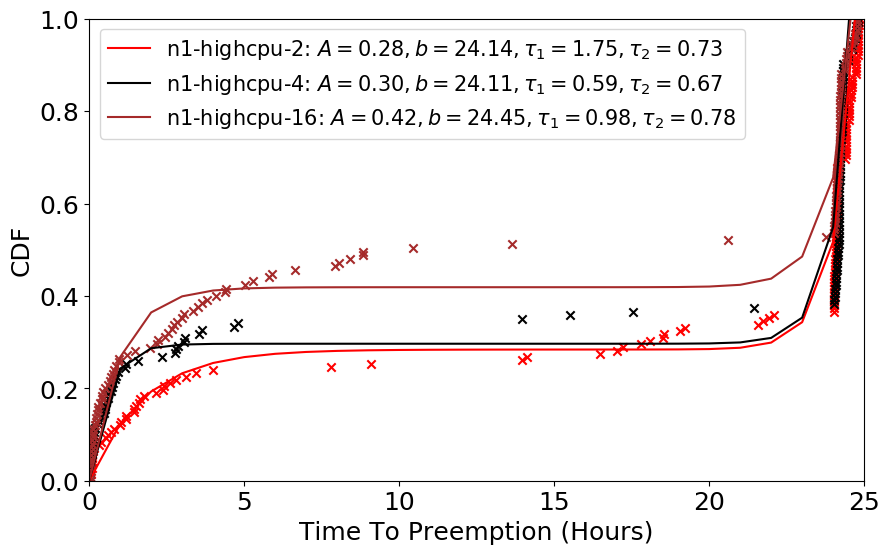

In [25]:
plot_for_comparison(all_data,['n1-highcpu-2','n1-highcpu-4','n1-highcpu-16'])

In [26]:
orig_params= np.array([ -3.25606377e-01,   4.63368111e-16,   2.51231468e+00,
         7.11346079e-01,   3.44815177e-01])
(A, B, tau1, tau2, C) = orig_params

In [27]:
tau1=2.5
tau2 = 0.7
B = math.pow(10,-16)
n2 = (A, B, tau1, tau2, C)

TypeError: func_approx_5_param_expon() missing 1 required positional argument: 'C'

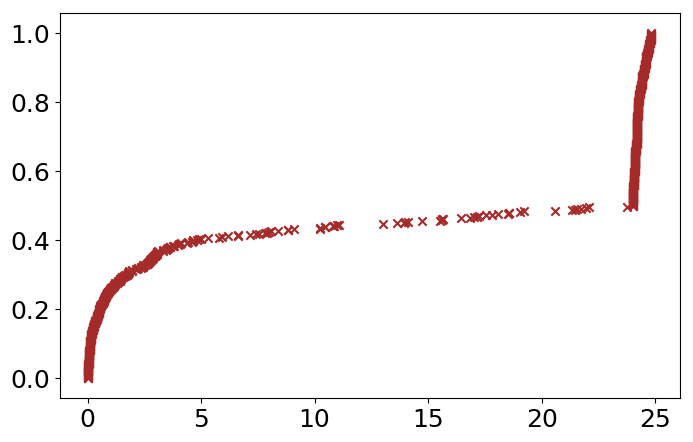

In [28]:
t=np.arange(0,26)
Y = np.sort(all_data_conc)
X = np.linspace(0,1,len(all_data_conc), endpoint=True)
matplotlib.rcParams.update({'font.size': 18})
fig,ax = plt.subplots()
fig.set_size_inches(8,5)
ax.scatter(Y, X, marker='x',color='brown')
ax.plot(t, func_approx_5_param_expon(t, *fit_params['optimized_params']), c='k',  label=r'Blended Exponential: $Ae^{-t/\tau_1}+Be^{-t/ \tau_2} +C$')
ax.plot(t, func_approx_5_param_expon(t, *n2), c='r',  label=r'lower tau')
ax.set_ylim((0,1))
ax.set_xlim((0,25))
ax.legend(fontsize='small')
ax.set_xlabel("Time To Preemption (Hours)")
ax.set_ylabel("CDF")

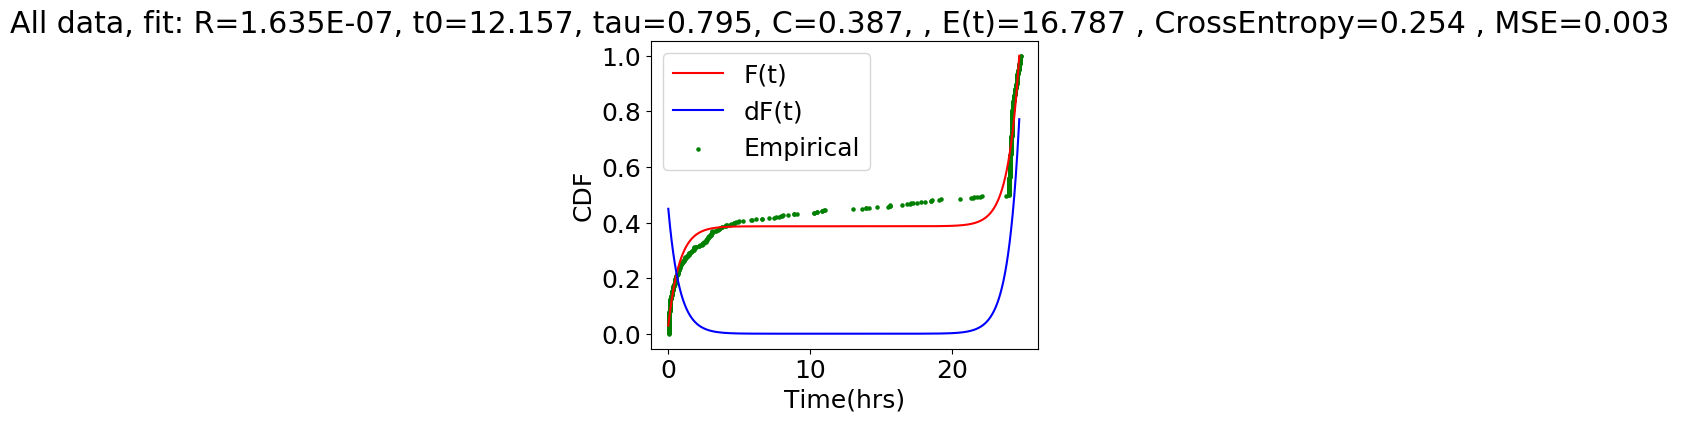

In [29]:
        
#Fit the data for all the data points
opt_params_all = fit_data(all_data_conc, func_approx, func_approx_exp)

plot_CDF("All data",opt_params_all, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)

# Curve fitting with sinh for different machine types usig scipy

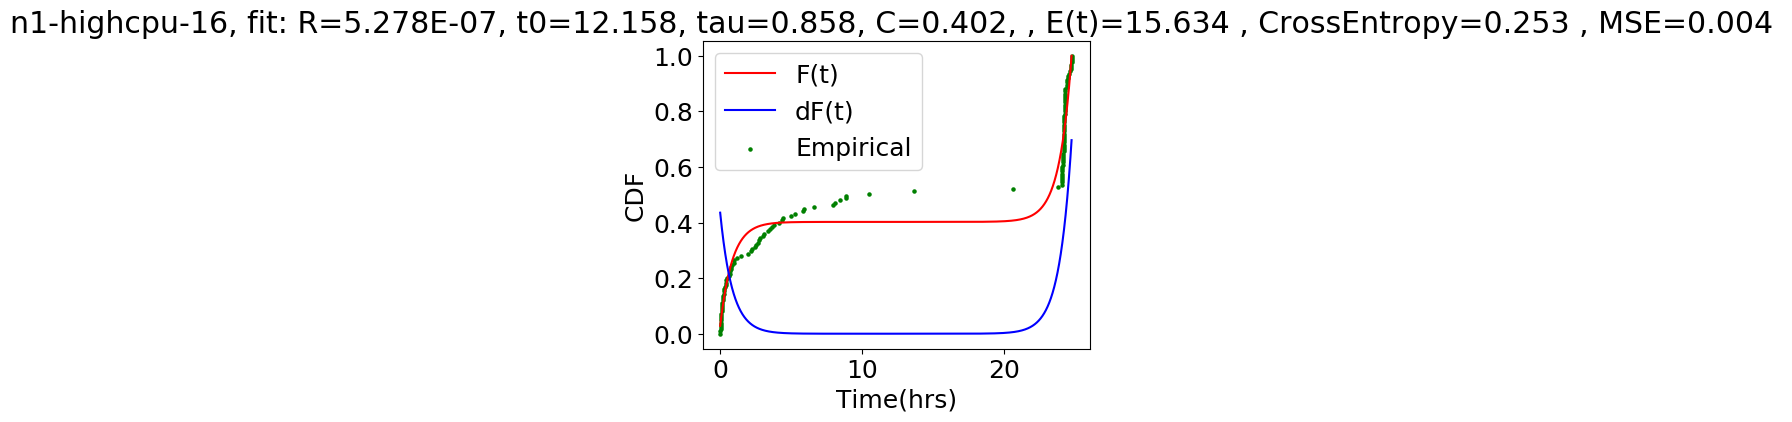

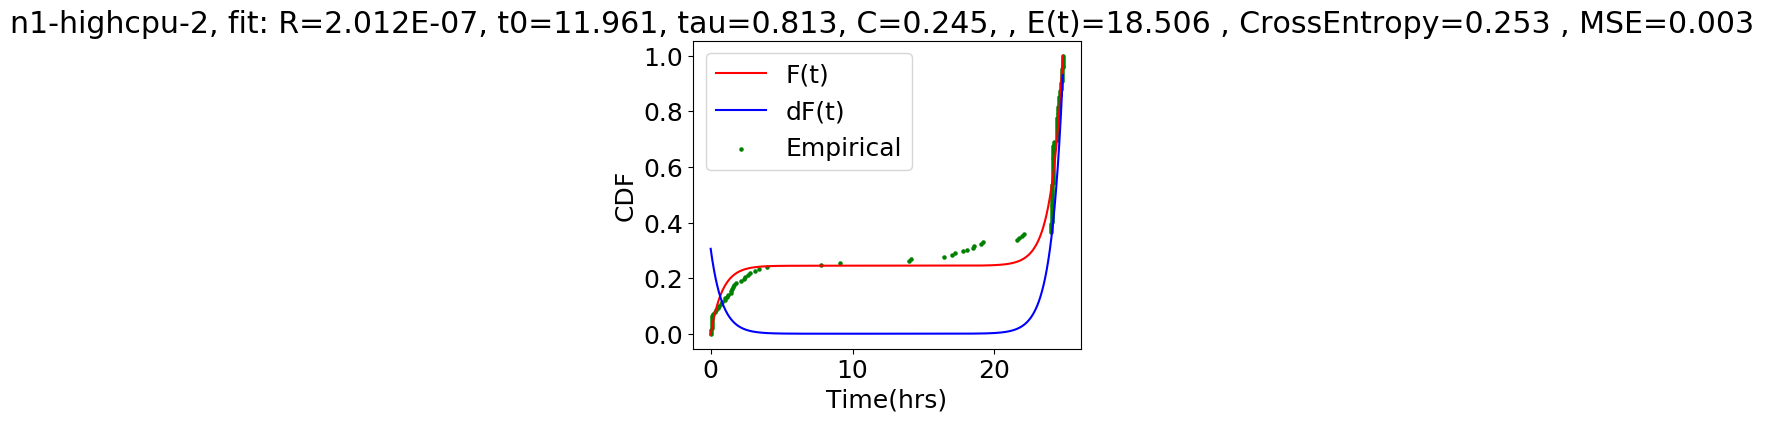

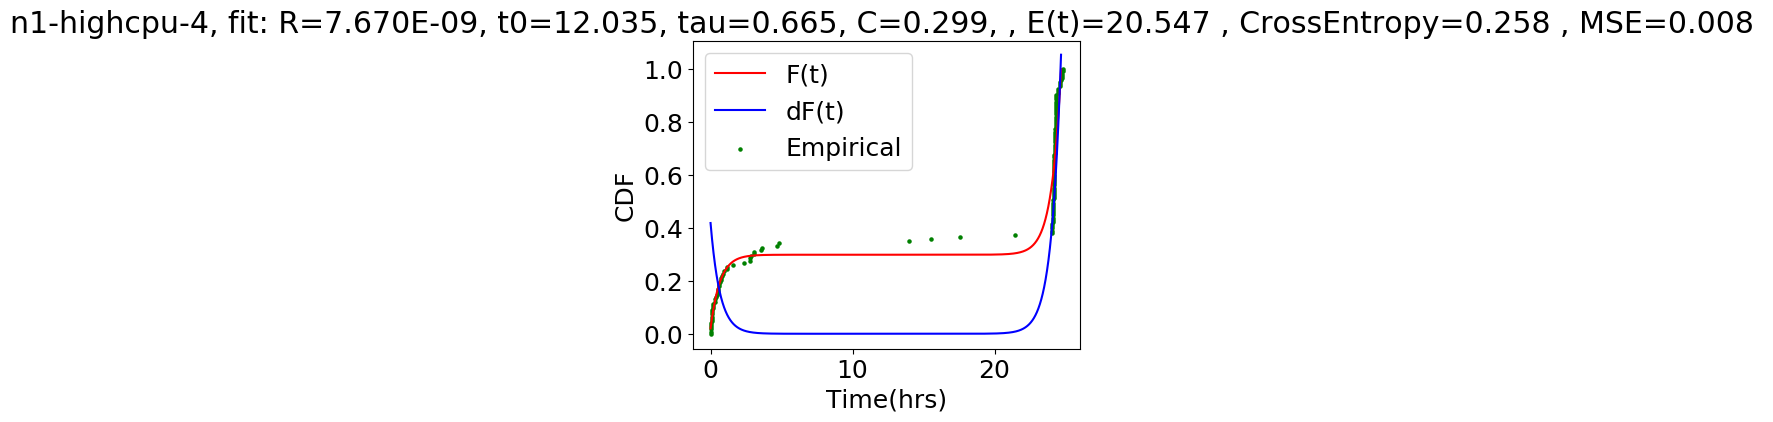

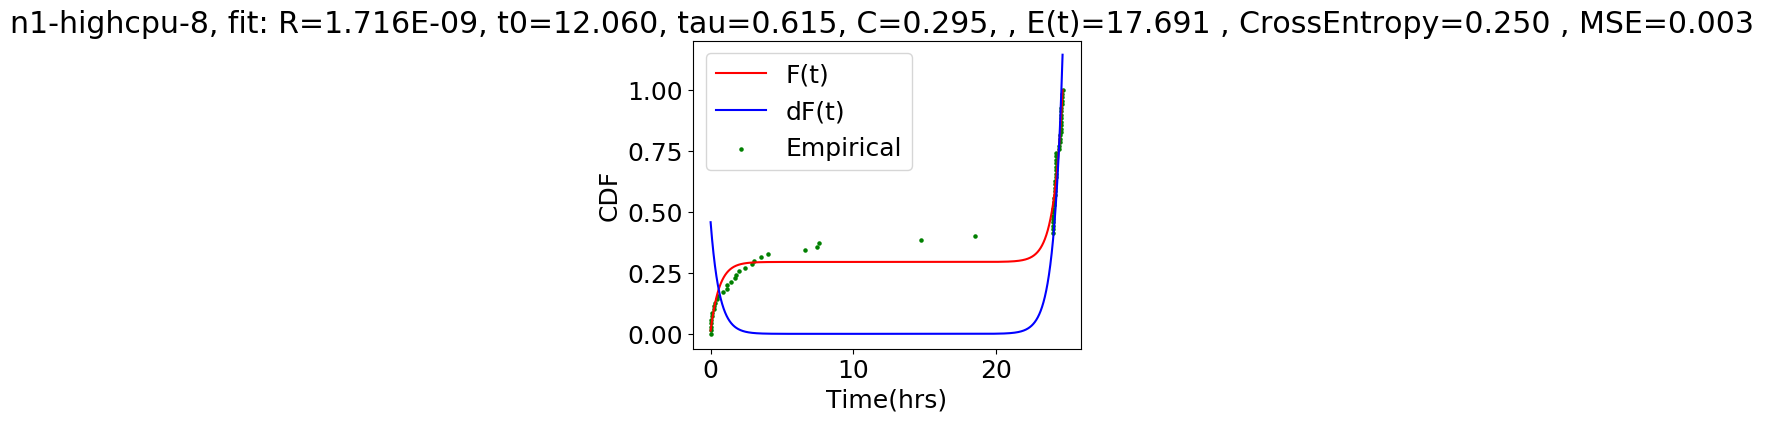

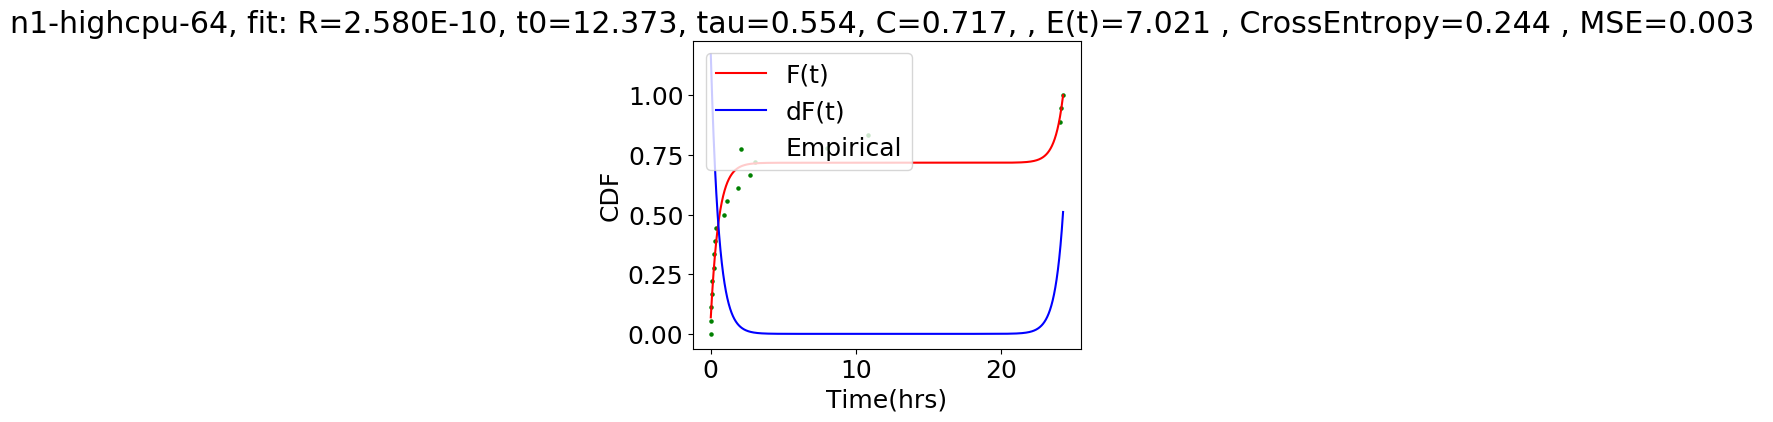

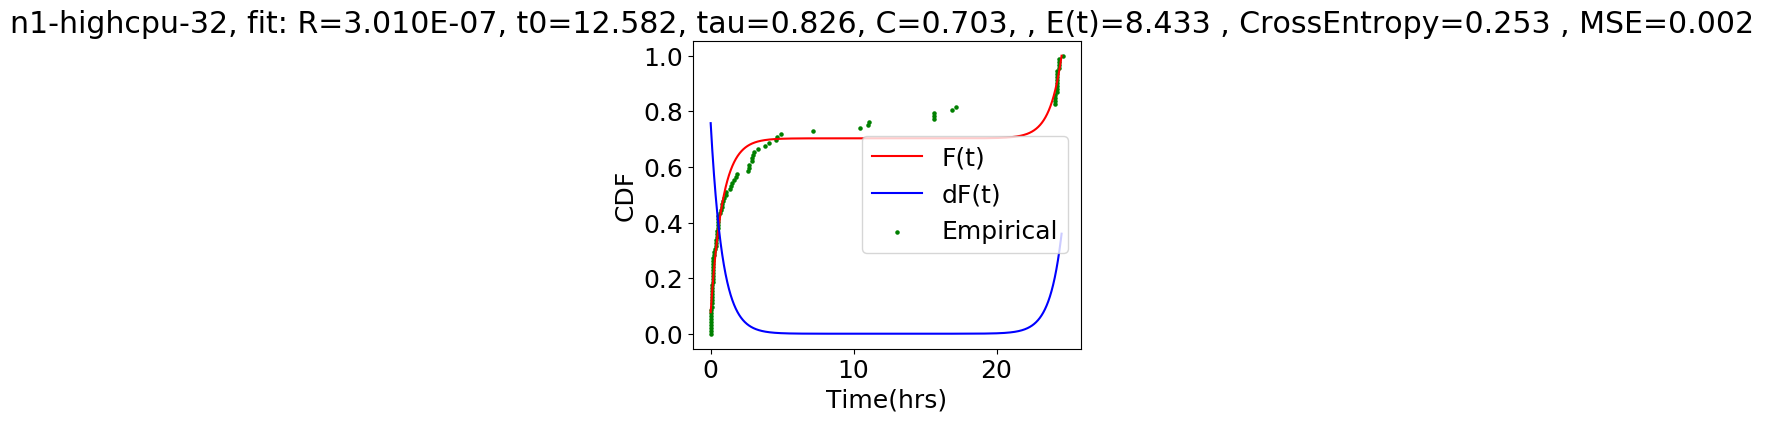

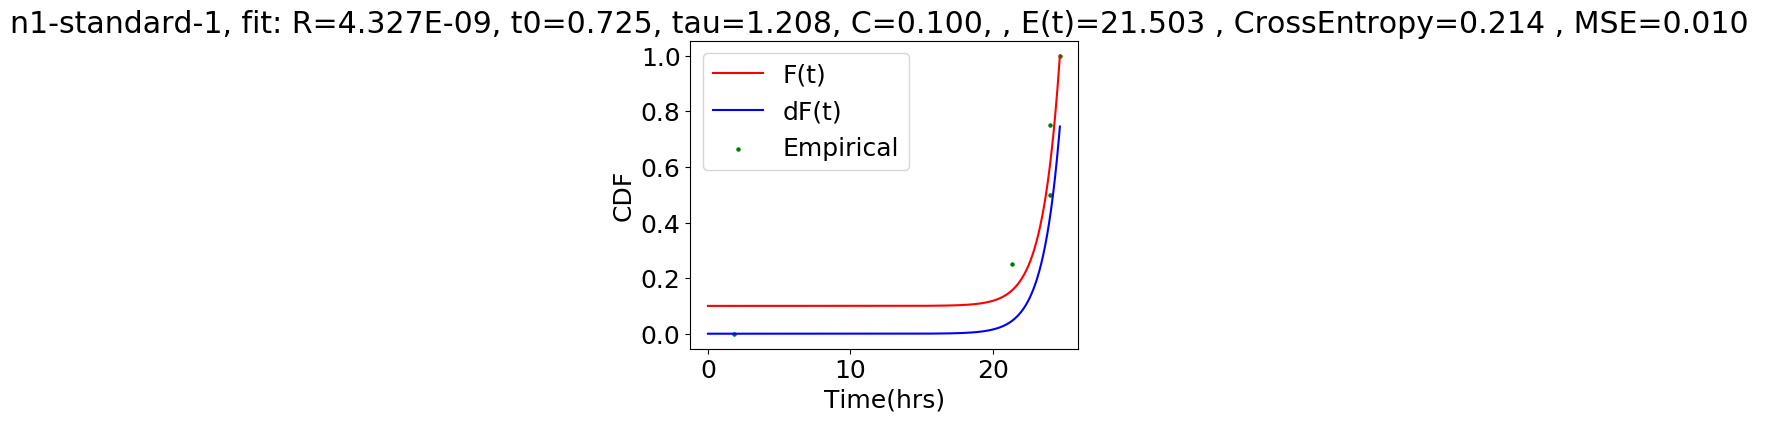

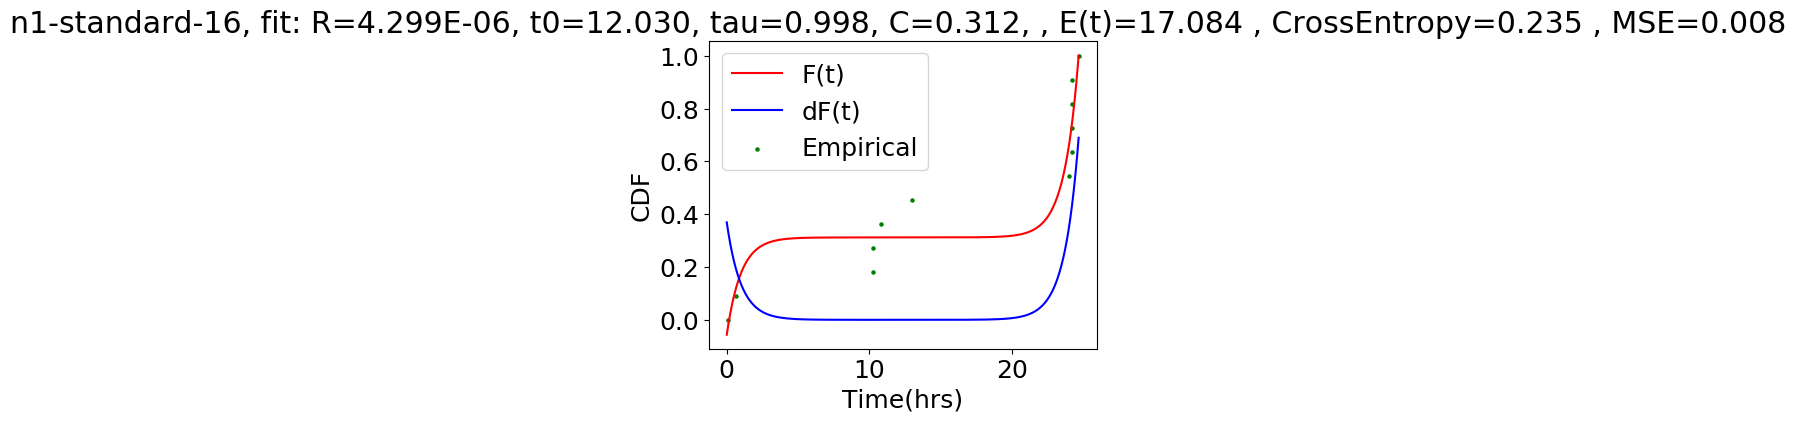

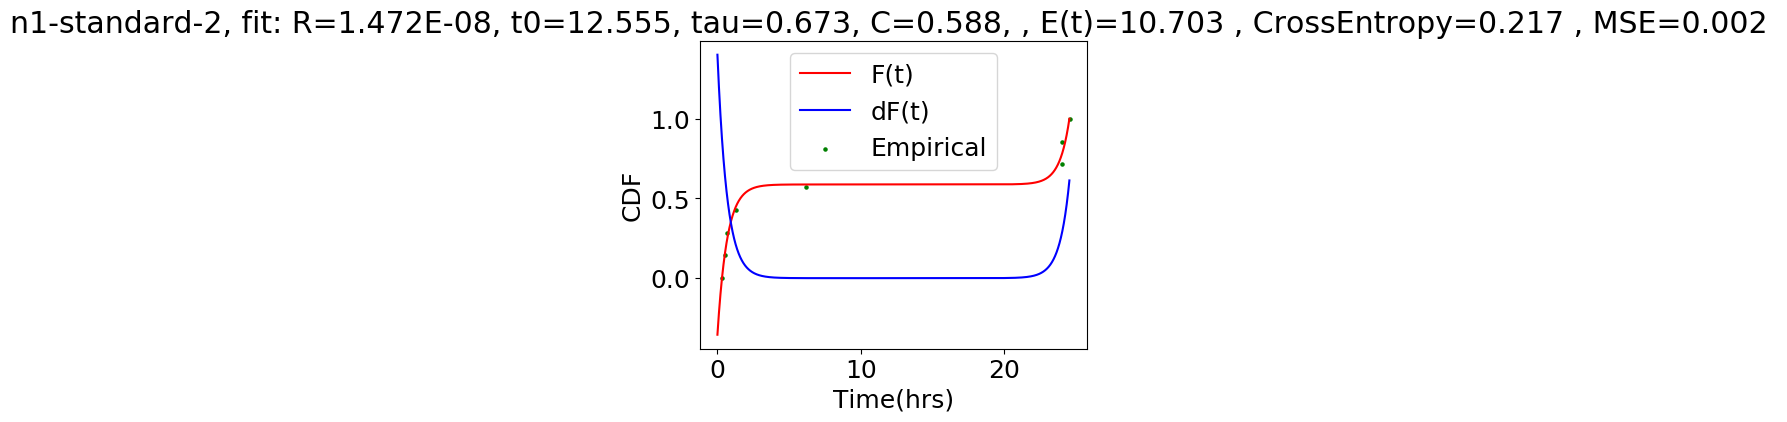

In [30]:
#generate curve fitting data for all the curves
optimized_parameters = fit_all_types(all_data, func_approx, func_approx_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)


# Curve fitting with exp for for all the results without considering machine type

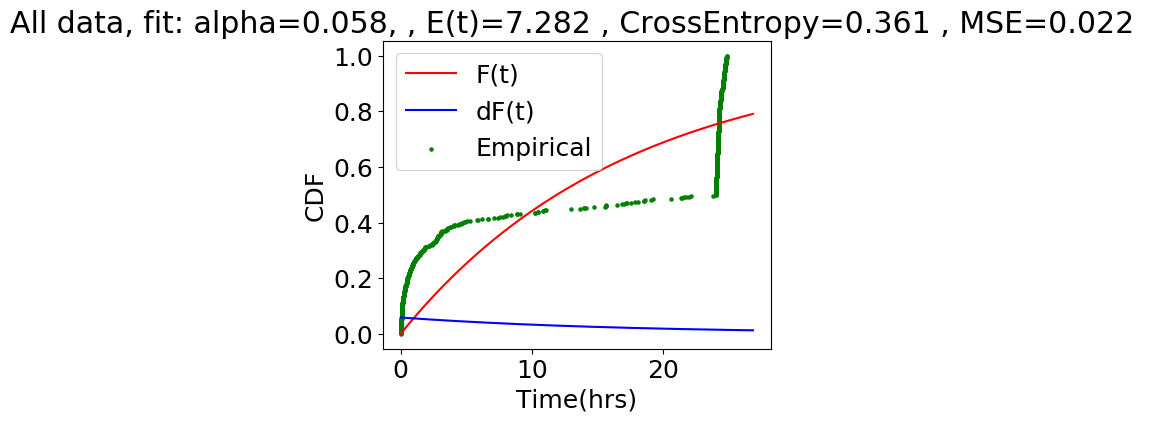

In [31]:
all_data_conc2 = []
for key, value in all_data.items():
    for i in range(value.shape[0]):
        all_data_conc2.append(value[i]) 

#Fit the data for all the data points
opt_params_all2 = fit_data(all_data_conc, func_approx_exponential, func_approx_exponential_exp)

plot_CDF("All data",opt_params_all2, func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)

# Curve fitting with exp for different machine types usig scipy

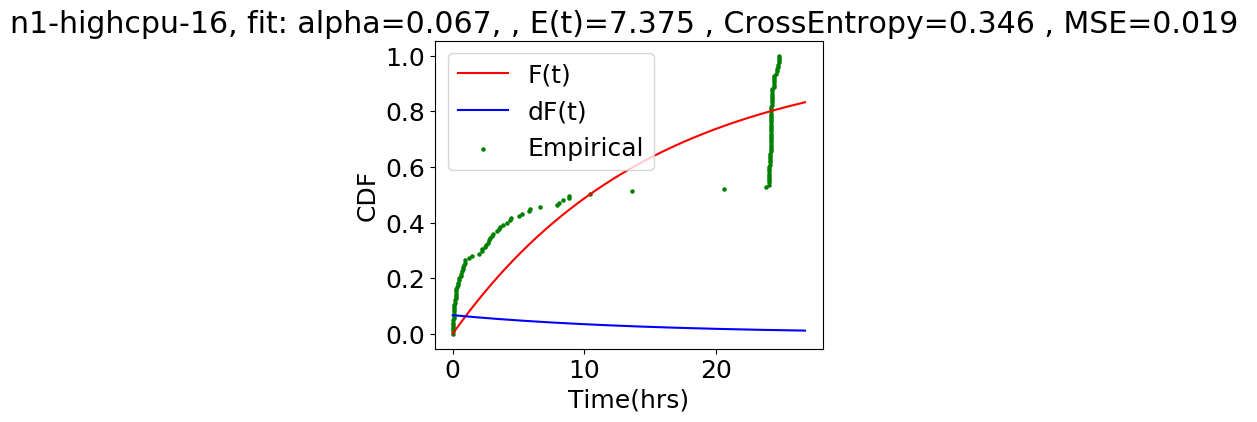

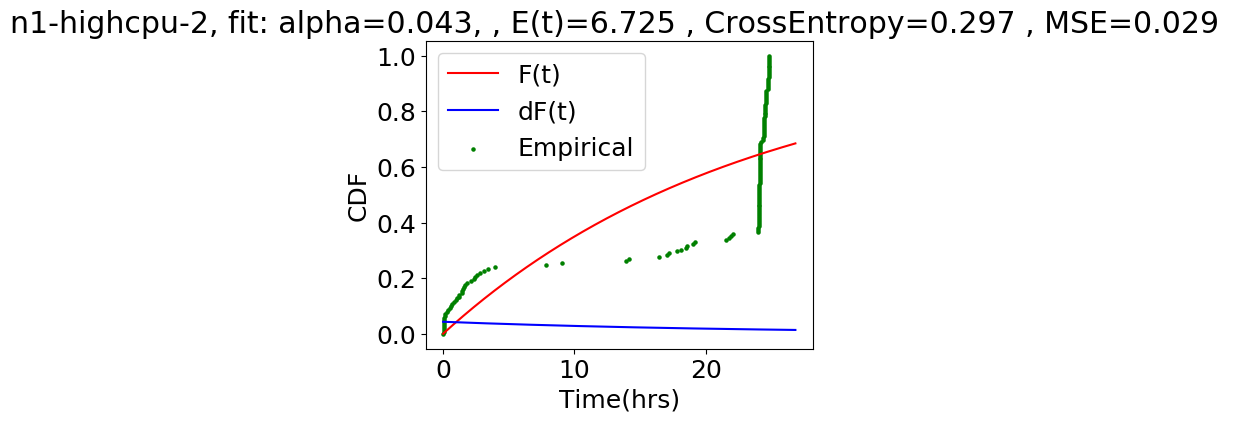

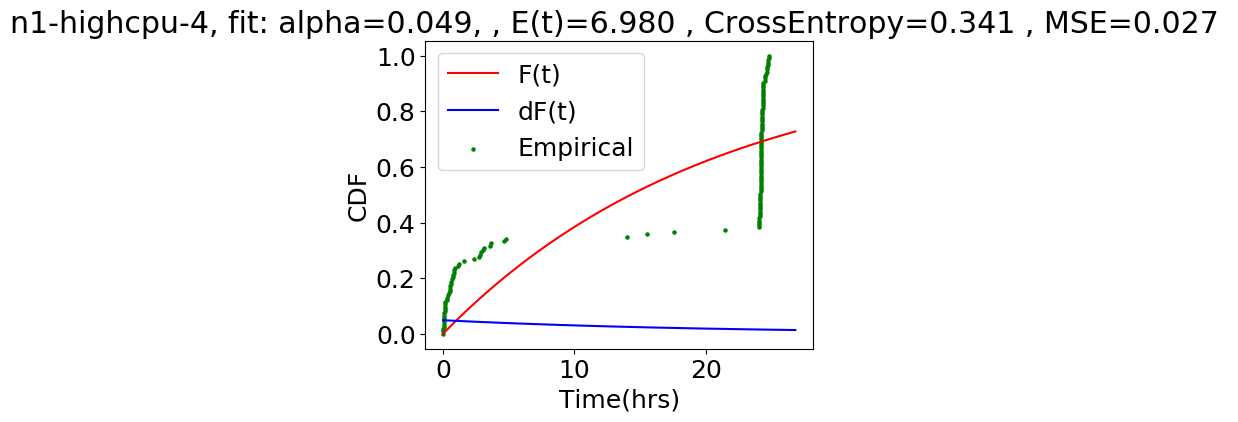

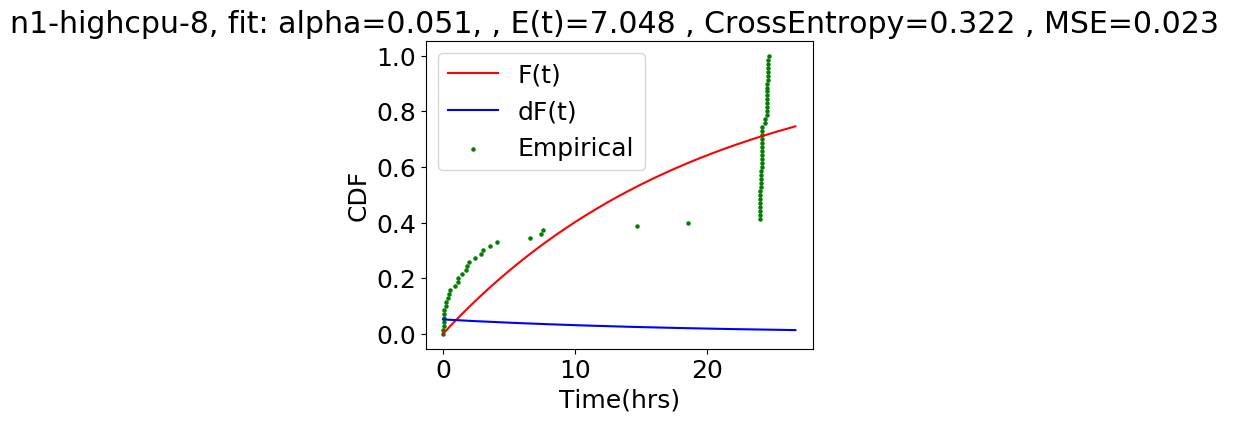

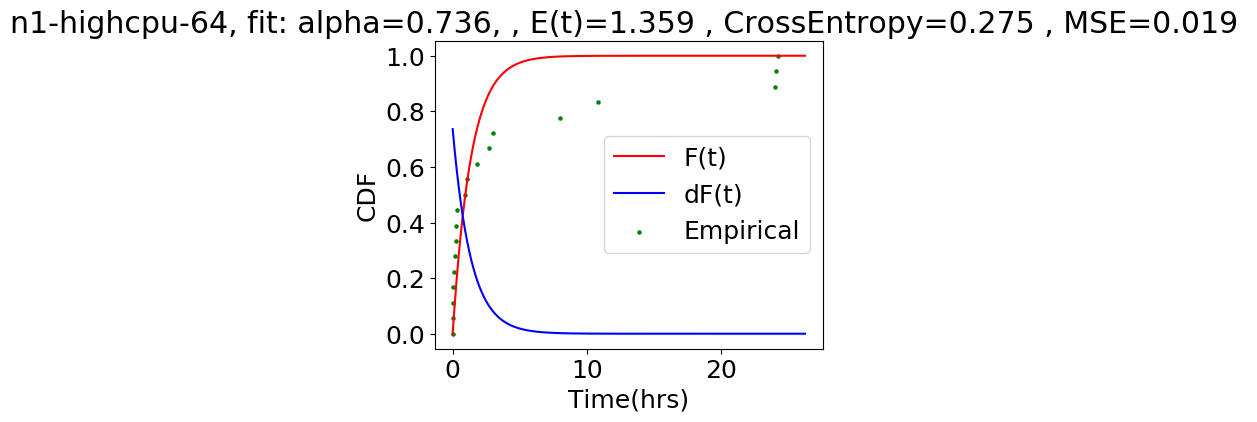

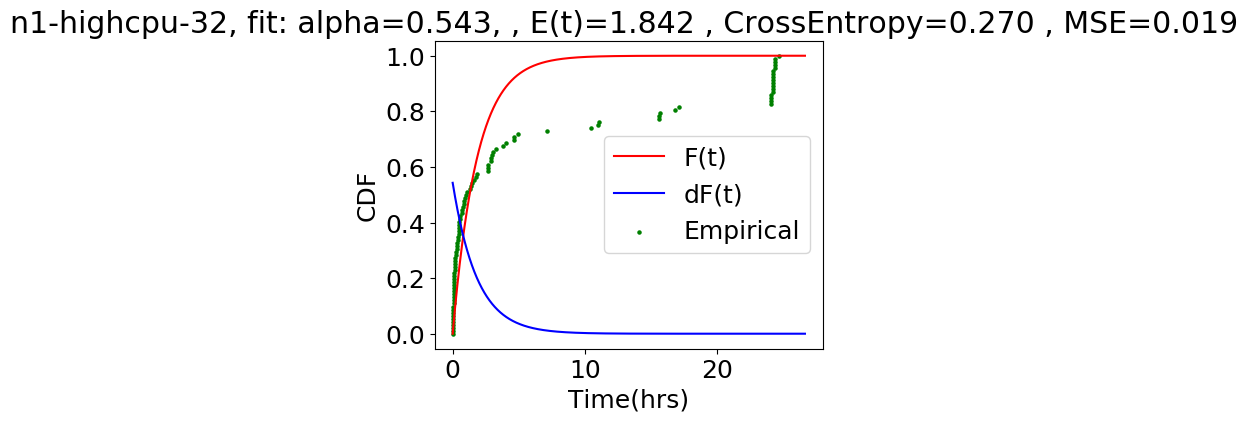

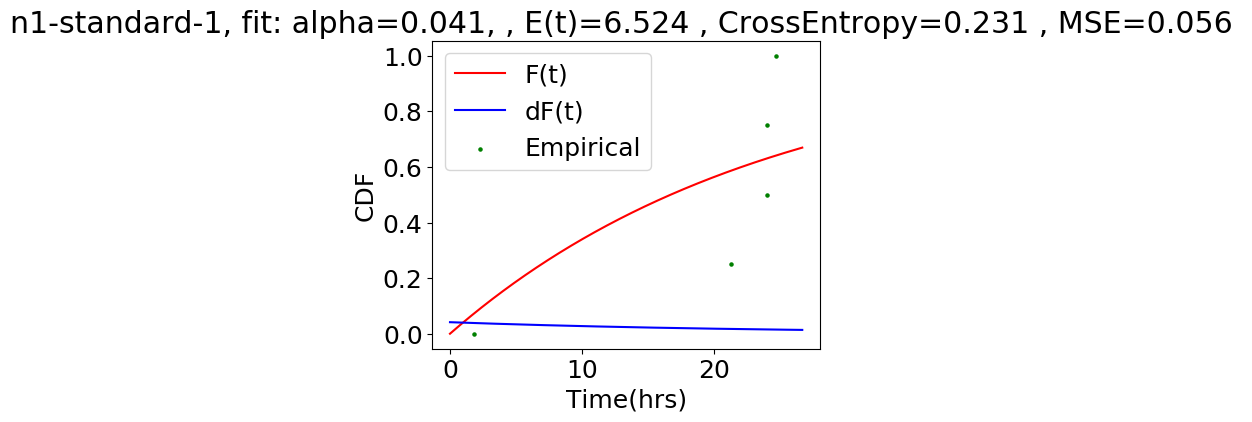

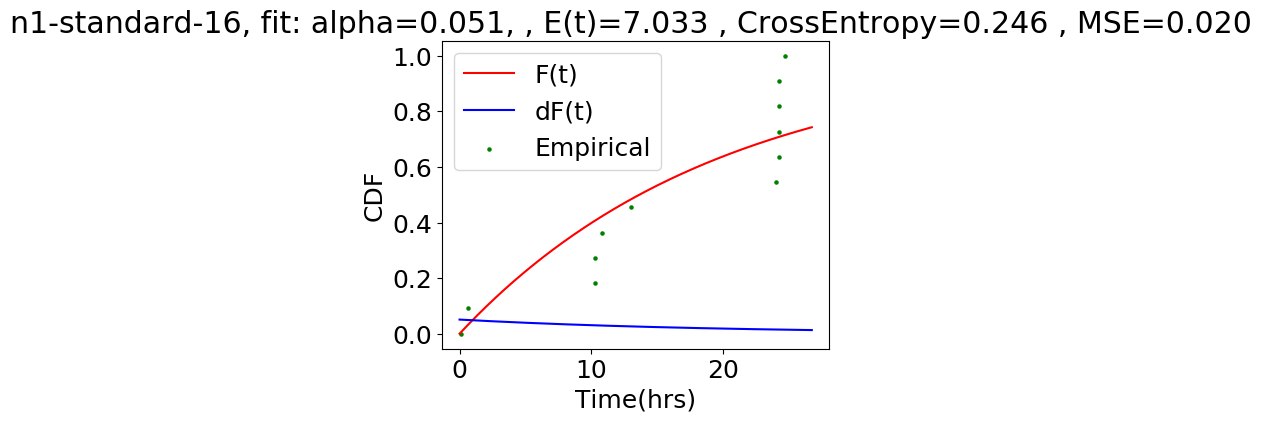

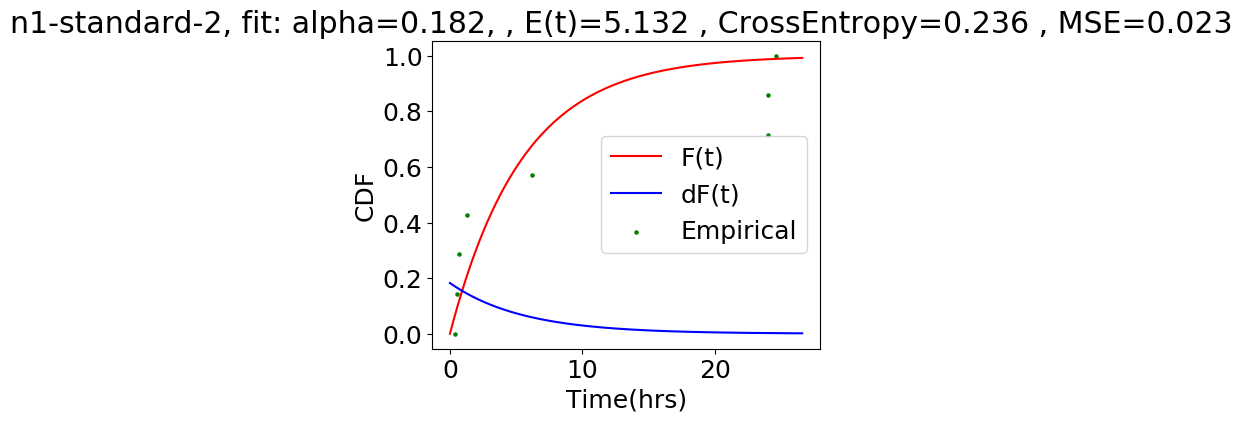

In [32]:
#generate curve fitting data for all the curves
optimized_parameters = fit_all_types(all_data, func_approx_exponential, func_approx_exponential_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters, func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)


# Plotting two functions in one plot

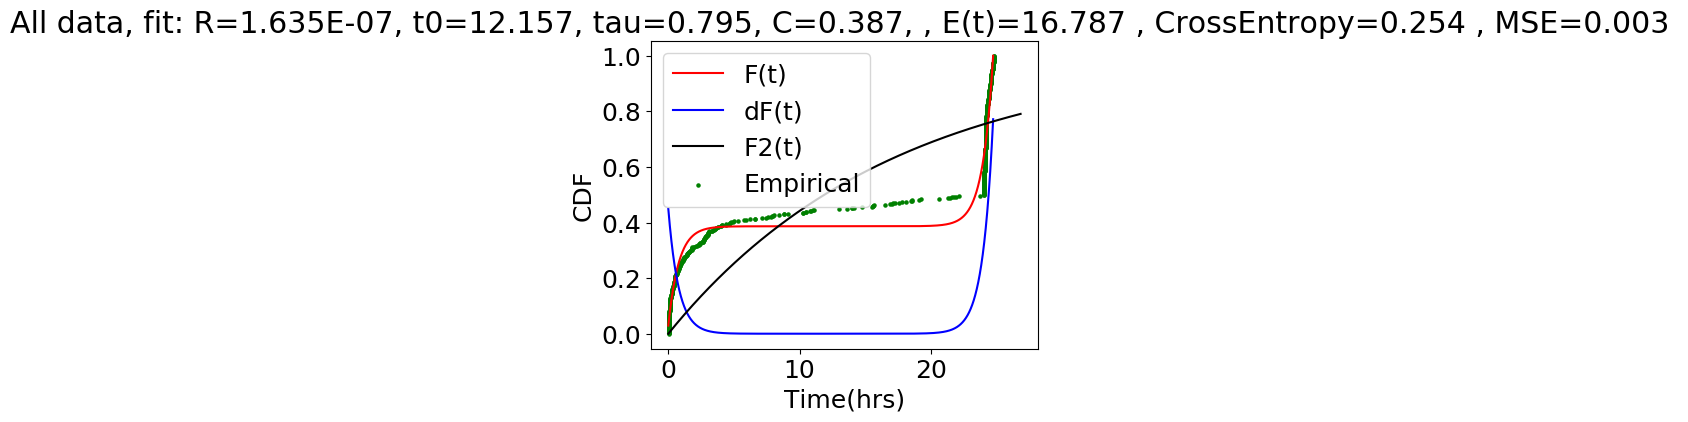

In [33]:
plot_two_CDF("All data",opt_params_all, opt_params_all2, func_approx, func_approx_dif, func_approx_inverse_by_interpolation,  
                 func_approx_exponential, func_approx_exponential_dif, func_approx_exponential_inverse_by_interpolation)

# Expected value comparison of scipy quad and analytical solution

In [34]:
#Analytical solution
#intergration to find the expected value
#dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
# When you integrate dPT by t: IdPT
IdPT = lambda t, R, t0, tau, C: R/tau* ( t*tau*np.sinh((t-t0)/tau) - (tau**2)*np.cosh((t-t0)/tau) )
t=opt_params_all['t'][-1]
ip_upper_bound = IdPT(t,*opt_params_all['optimized_params'])
t=opt_params_all['t'][0]
ip_lower_bound = IdPT(t,*opt_params_all['optimized_params'])
#accroding to mean value theorm
expected_value = (ip_upper_bound - ip_lower_bound)
expected_value

16.786541137796597

In [35]:
#Numerical Integration
dPT = lambda t, R, t0, tau, C: t*R*np.cosh((t-t0)/tau)/tau
I = quad(func=dPT, a=opt_params_all['t'][0], b=opt_params_all['t'][-1],args=tuple(opt_params_all['optimized_params']))
#accroding to mean value theorm
expected_value = I[0]
expected_value

16.786541137796597